# Neural Networks, Tree Rings, Drought in Contiguous US. 

This code can be used to have tree rings reconstruct a climate index using Neural Networks and compare to a linear method used by Cook et al (1999). In difference to the linear method, here, the closest $n$ stands can be used rather than those at a certain distance. 

In difference to the Cook et al methodology, this will use the 2.5x2.5 degree scPDSI grid from https://www.esrl.noaa.gov/psd/data/gridded/data.pdsi.html

#### AUTHOR: Aleyda M Trevino

#### EMAIL: atrevino@g.harvard.edu OR aleydatrevinot@gmail.com

#### DATE OF LAST UPDATE: May 24, 2021

Things might change to make the code more efficient, easier to read, etc. 

In [1]:
# IMPORTANT, ARE YOU TESTING OR CHANGING THINGS INSIDE? IF SO MAKE SURE TO PUT 1, 
# AND SAVE CURRENT VERSION AS THE DATE VERSION
TestingCode = 0

# For other saving parameters
NN_SaveModels = 0
NN_SaveResults = 1
NN_SaveBasicResults = 1

In [3]:
# PACKAGES NEEDED

# NUMPY ET AL
import numpy as np
from numpy.random import randn
from numpy.fft import rfft
from numpy.random import seed
import pandas as pd
import copy

# PLOTTING
import matplotlib.pyplot as plt
from matplotlib.pyplot import loglog
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import mpl_toolkits.axes_grid1.axes_size as Size


# SCIPY
import scipy
import scipy.io as scio
from scipy.signal import butter, lfilter, filtfilt
from scipy import signal, stats

# OTHER MATHS
import math
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics, linear_model

# READING DATA FILES
import h5py
import netCDF4 as nc4

# SAVING TIME DETAILS
import time
import datetime as dt

# For mapping/is_land
import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep

# For NN
import tensorflow as tf
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, LeakyReLU, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.core import Dense, Activation
from tensorflow import set_random_seed
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

# ACCESS OS
import os

# Used for saving things
StartTime = time.time()
StartStat = copy.deepcopy(dt.datetime.now())

# YOU ARE IMPORTING PARAMETERS IF FOLLOWING IS 1
ImportParams = 1
if ImportParams == 1:
    print('You are importing parameters')
    OdysseyIndex = 0
    
# If using Jupyter Notebook, this will expand the coding window to fill the internet window you are using. 
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
    
OdysseyTest = str(1)

# Where are the import parameters being downloaded from: 
DownloadLocation = './Data/InputSeries_200703-1812.mat'

# File source for climate 
NN_ClimFileSou = './Data/pdsi.mon.mean.selfcalibrated.nc'

# Stand data 
TreeFileSource = './Data/NN_Tree_Data.mat'

# Where to save the results
SaveResultsFolder = './Results/'




Using TensorFlow backend.


You are importing parameters


In [5]:
SecStart = time.time()
SecName = "Functions that will be used"
        
        
# FUNCTIONS THAT WILL BE USED
# Figure specification
plt.rcParams['figure.figsize'] = [25,25]

# For determining whether a point is on land or water
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')
land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    if x>180:
        x = x-360
    return land.contains(sgeom.Point(x, y))


# Finding the nearby stands to a site
def Distance_Earth(lat1, long1, lat2, long2):
    REarth = 6371

    degrees_to_radians = np.pi/180.0

    phi1 = np.multiply(90.0*np.ones(np.shape(lat1)) - lat1,np.ones(np.shape(lat1))*degrees_to_radians)
    phi2 = np.multiply(90.0*np.ones(np.shape(lat1)) - lat2,np.ones(np.shape(lat1))*degrees_to_radians)

    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians

    cos = (np.multiply(np.multiply(np.sin(phi1),np.sin(phi2)),np.cos(theta1 - theta2)) + 
           np.multiply(np.cos(phi1),np.cos(phi2)))
    arc = np.arccos( cos )
    dist = arc*REarth
    return dist

# For the AR processes used
class AutoRegression(object):
    '''
    AR '''
    def __init__(self, TimeSeries1, pMin=1, pMax=12,AICcOrBIC='AIC'):
        self.TimeSeries = TimeSeries1[:]
        self.RawTimeSeries = TimeSeries1[:]
        self.pMin = pMin
        self.pMax = pMax
        self.AICcOrBIC = AICcOrBIC
        
        RawTimeSeries = TimeSeries1[:]
        TimeSeries = self.TimeSeries
        pMin = self.pMin
        pMax = self.pMax
        AICcOrBIC = self.AICcOrBIC
        
        def regressAR(x1,y1):
            from sklearn import linear_model
            regr = linear_model.LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
            regr.fit(x1,y1)
            YReg = regr.predict(x1).reshape(-1,1)
            BetaCoef = regr.coef_.reshape(-1,1)
            return YReg, BetaCoef        
        
        IsNanTimeSeries = np.isnan(TimeSeries)
        RawTimeSeries = TimeSeries
        TimeSeries = TimeSeries[~IsNanTimeSeries].reshape(-1,1)
        self.ARN = len(TimeSeries)
        ARN = self.ARN
        
        if AICcOrBIC == 'AIC':
            pMaxAct = np.nanmin((ARN-3,pMax))
        else:
            pMaxAct = pMax
                
        
        M1 = np.zeros((ARN,ARN))
        Phi = np.zeros((pMax,pMax))
        Epsilon = np.zeros((ARN,pMax))
        Sig = np.zeros((1,pMax))
        AICc = np.zeros((1,pMax))
        AICPoly = np.zeros((1,pMax))
        AICLog = np.zeros((1,pMax))
        BIC = np.zeros((1,pMax))
        
        for i in range(ARN):
            for j in range(ARN):
                if i-j>0:
                    M1[i,j] = TimeSeries[i-j-1]
                else:
                    M1[i,j] = 0
                    
        for p in range(pMin,pMaxAct+1):
            InterPhi = []
            InterReg = []
            InterInt = []
            InterReg, InterPhi = regressAR(M1[:,0:p],TimeSeries) #, InterInt 
            Phi[0:p,p-1] = InterPhi.reshape(-1)
            Epsilon[0:,p-1] = TimeSeries.reshape(-1,1).reshape(-1) - InterReg.reshape(-1,1).reshape(-1)
            Sig[0,p-1] = np.nanstd(Epsilon[0:,p-1])
        
            AICc[0,p-1] = ARN*np.log(Sig[0,p-1]**2)+2*(p+1)+2*(p+1)*(p+2)/(ARN-p-2)
            AICPoly[0,p-1] = 2*(p+1)+2*(p+1)*(p+2)/(ARN-p-2)
            AICLog[0,p-1] = ARN*np.log(Sig[0,p-1]**2)
            BIC[0,p-1] = (ARN)*np.log(Sig[0,p-1]**2)+p*np.log(ARN)

        self.AICc = AICc
        self.AICPoly = AICPoly
        self.AICLog = AICLog
        self.M1 = M1
        self.BIC = BIC
        self.Sig = Sig
        self.Epsilon = Epsilon

        if AICcOrBIC == 'AIC':
            self.ARP = np.argmin(AICc[0,pMin-1:pMaxAct-1])+ pMin
        else:
            self.ARP = np.argmin(BIC[0,pMin-1:pMaxAct-1])+ pMin
        
        InterPhi = []
        InterReg = []
        InterInt = []
        InterReg, InterPhi = regressAR(M1[:,0:self.ARP],TimeSeries) #, InterInt
        ARTimeSeries = TimeSeries - InterReg
        self.ARCoefs = InterPhi
        self.ARInter = InterInt
        
        self.check = np.zeros(np.shape(TimeSeries))
        self.check[0,0] = ARTimeSeries[0,0]

        for i in range(1,self.ARN): 
            self.check[i,0] = (ARTimeSeries[i,0] + 
                               np.dot(self.check[np.nanmax((i-self.ARP,0)):i,0],
                                      np.flip(InterPhi.reshape(-1,1)[0:np.nanmin((self.ARP,i)),
                                                                     0],0)).reshape(-1,1))
        
        if np.sum(np.abs(self.check - TimeSeries))>.01:
            print('Error found')
            self.Error = 1
        
        self.ARTimeSeries = np.nan*np.ones(np.shape(RawTimeSeries.reshape(-1,1)))
        self.ARTimeSeries[~IsNanTimeSeries.reshape(-1),0] = ARTimeSeries.reshape(-1)
        self.TimeSeries = self.RawTimeSeries[:]

# Undoing the AR process at the end
def InvAR(ARTimeSeries,PhiCoefs):
    TimeSeries = np.zeros(np.shape(ARTimeSeries.reshape(-1,1)))
    TimeSeries[0,0] = ARTimeSeries[0,0]
    ARN = np.max(np.shape(ARTimeSeries))
    ARP = np.max(np.shape(PhiCoefs))

    for i in range(1,ARN): 
        TimeSeries[i,0] = (ARTimeSeries[i,0] +
                      np.dot(TimeSeries[np.nanmax((i-ARP,0)):i,0],
                             np.flip(PhiCoefs.reshape(-1,1)[0:np.nanmin((ARP,i)),0],0)).reshape(-1,1))
    return TimeSeries


def RegressNoInt(x1,y1):
    
    regr = linear_model.LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)
    regr.fit(x1,y1)
    YReg = regr.predict(x1).reshape(-1,1)
    BetaCoef = regr.coef_.reshape(-1,1)
    return YReg, BetaCoef 

# finding the significantly correlated stands to a site's climate
def SigCorrel(DoF, Alpha):
    Co = np.linspace(0,1,10000)
    Tx = np.linspace(0,100,100000)
    Tcdf = stats.t.cdf(Tx,DoF)
    TSig = Tx[np.argmin(np.abs(Tcdf-(1-Alpha/2)))]
    CoFun = (np.sqrt(DoF-2)*np.multiply(Co,1./(np.sqrt(np.ones(np.shape(Co))-np.multiply(Co,Co)))))
    CoSig = Co[np.argmin(np.abs(CoFun-TSig))]
    return CoSig

# defining n of AR(n)
def RegressAICc(x1,y1):
    Resid = np.zeros(np.shape(x1))
    Resid.fill(np.nan)
    ResidStDev = np.zeros(np.shape(x1)[1])
    ResidStDev.fill(np.nan)
    AICc = np.zeros(np.shape(x1)[1])
    AICc.fill(np.nan)
    AICcN = np.shape(x1)[0]
    for i in range(np.min([np.shape(x1)[1],AICcN-3])):
        p=i*1.0
        yTry, yCoef = RegressNoInt(x1[:,0:i+1],y1)
        Resid[:,i] = (y1.reshape(-1,1)-yTry.reshape(-1,1)).reshape(-1)
        ResidStDev[i] = np.std(Resid[:,i])
        AICc[i] = AICcN*np.log(ResidStDev[i]**2)+2*(p+1)+2*(p+1)*(p+2)/(AICcN-p-2)
    AICcMin = np.argmin(AICc)+1
    YReg, BetaCoef = RegressNoInt(x1[:,0:AICcMin],y1)
    return YReg, BetaCoef, AICcMin

# Example parameters that can be used in the following function
#NN_Params = [3,11,'keras.layers.LeakyReLU(alpha=0.3)',1.3,[0,1,1],50]

# THIS IS THE FUNCTION THAT DEALS WITH THE NN MECHANICS. 
def NN_Calc(x_tr,y_tr,x_va,x_to,x_other,Params):
    '''
    Runs the training and testing on a Random Forest
    INPUTS: 
        Training and testing:
            x_tr: x training [yrs train,num]
            y_tr: y training [yrs train,1]
            x_va: x validate [yrs validate,num]
            x_to: x total [yrs total,num]
    
        Params: 
            Params[0]
            # Test Layers
            TestLayers = 2
            
            Params[1]
            # Hidden nodes
            HiddenNodes = 11
            
            Params[2]
            # Activation Term
            Activation = 'keras.layers.LeakyReLU(alpha=0.3)'

            
            Params[3]
            # L2 Regularization weight
            TestRegWeight  = 1.3

            Params[4]
            # Dropout Term [Input, all, every nth layer incl layer 1]
            TestDropout = [0,0,0]
            
            Params[5]
            # Training epochs
            TrainEpochs = [0,0,0]
            
    
    OUTPUT:
        y_ReconTr: recon training
        y_ReconVa: recon testing
        y_ReconTo: recon total
        NN_Importance: importance of inputs (features)
        NN_Sens_Indiv_Mean: sensitivity analysis per stand (other stands mean) [x_used, y_result]
        NN_Sens_Indiv_Mean: sensitivity analysis per stand (other stands real)
        NN_Sens_Group: sensitivity wrt group
        NN_Sens_Group_Same: sensitivity wrt group same input'''

    #seed(Params[3])
    keras.backend.clear_session()
    Model = Sequential()
    
    NN_UseEarlyStopping = 0
    NN_ActivationStatement = 'LeakyReLU'
    NN_RegType = 'l2'
    
    NN_HiddenLayers = Params[0]
    NN_HiddenNodes = Params[1]
    NN_Activation = Params[2]
    NN_RegWeight = Params[3]
    NN_DropoutInput = Params[4][0]
    NN_Dropout = Params[4][1]
    NN_DropoutMod = Params[4][2]
    NN_TrainEpochs = Params[5]

    # Addind the layers
    Model.add(Dropout(NN_DropoutInput))
    for j in range(NN_HiddenLayers):

        if NN_ActivationStatement == 'LeakyReLU':
            eval('Model.add(Dense(units='+str(int(NN_HiddenNodes))+',input_dim=np.shape(x_tr)[1],'+
                 'kernel_regularizer=regularizers.'+NN_RegType+'('+str(NN_RegWeight)+')))')
            eval('Model.add('+NN_Activation[NN_Activation.find('LeakyReLU'):]+')')    
        else:
            eval('Model.add(Dense(units='+str(int(NN_HiddenNodes))+',input_dim=np.shape(x_tr)[1],'+
                 'activation='+NN_Activation+',kernel_regularizer=regularizers.'+NN_RegType+'('+str(NN_RegWeight)+')))')
        
        # adding dropout every nth layer
        if j%NN_DropoutMod == 0:
            Model.add(Dropout(NN_Dropout))

    # linear final layer
    Model.add(Dense(units=1,activation='linear'))
    
    # compile and loss function
    # can use 'loss=tf.keras.losses.MeanAbsoluteError()' or "mean_absolute_error"
    Model.compile(loss='mean_squared_error', optimizer='adam')
    
    # Are you using early stopping (check earlier, usually no)
    if NN_UseEarlyStopping == 1:
        ModelCallbacks = [EarlyStopping(monitor='val_loss', patience=NN_EarlyStoppingPatience),
                             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
        history = Model.fit(x_tr,#train_features, # Features
                          y_tr, # Target vector
                          epochs=50, # Number of epochs
                          callbacks=ModelCallbacks, # Early stopping
                          verbose=0, # Print description after each epoch
                          batch_size=1, # Number of observations per batch
                          validation_data=(x_va, y_va)) # Data for evaluation
    else:

        Model.fit(x_tr, y_tr, epochs=NN_TrainEpochs, batch_size=1,verbose=0);

    
    y_ReconVa = Model.predict(x_va).reshape(-1,1)
    y_ReconTr = Model.predict(x_tr).reshape(-1,1)
    y_ReconTo = Model.predict(x_to).reshape(-1,1)
    y_ReconOther = Model.predict(x_other).reshape(-1,1)
    # print('\tDone train, test, total.')
    
    # Sensitivity of group (change all inputs from min to max concurrently), might have something funky happening as the covariance structure of growth is changing
    x_Sens_Group = np.sort(x_to,axis=0)
    y_Sens_Group = Model.predict(x_Sens_Group).reshape(-1,1)
    NN_Sens_Group = [copy.deepcopy(x_Sens_Group),copy.deepcopy(y_Sens_Group)]
    #print('\tDone RF Sens Group.')
    
    # Sensitivity of group but all stands are given the same growth
    x_Sens_Group_Same = np.tile(np.linspace(np.min(x_to),np.max(x_to),np.shape(x_to)[0]).reshape(-1,1),(1,np.shape(x_to)[1]))
    y_Sens_Group_Same = Model.predict(x_Sens_Group_Same).reshape(-1,1)
    NN_Sens_Group_Same = [copy.deepcopy(x_Sens_Group_Same),copy.deepcopy(y_Sens_Group_Same)]
    
    # go one by one input, replace rest with mean.
    y_Sens_Indiv = np.zeros(np.shape(x_to))
    y_Sens_Indiv.fill(np.nan)
    for i in range(np.shape(x_to)[1]):
        x_Sens_Indiv = np.tile(np.mean(x_to,0),[np.shape(x_to)[0],1])
        x_Sens_Indiv[:,i] = copy.deepcopy(np.sort(x_to[:,i]))
        y_Sens_Indiv[:,i] = Model.predict(x_Sens_Indiv).reshape(-1)
    NN_Sens_Indiv_Mean = [copy.deepcopy(np.sort(x_to,axis=0)),copy.deepcopy(y_Sens_Indiv)]
    #print('\tDone RF Sens Indiv, all other mean.')
    
    # change the input of each one separately by perturbation
    y_Sens_Indiv = np.zeros(np.shape(x_to))
    y_Sens_Indiv.fill(np.nan)    
    # too slow: for i in range(np.shape(x_to)[0]): # Time
    for j in range(np.shape(x_to)[1]): # proxy num
        Inter_Added = np.zeros((np.shape(x_to)))
        Inter_Added[:,j] = 1*np.std(x_to[:,j])*np.ones((np.shape(x_to)[0])).reshape(-1)
        x_Sens_Indiv =  x_to + Inter_Added
        y_Sens_Indiv[:,j] = (Model.predict(x_Sens_Indiv).reshape(-1) - 
                            Model.predict(x_to).reshape(-1))
    NN_Sens_Indiv_Sprt = [x_to,copy.deepcopy(y_Sens_Indiv),y_ReconTo]
    # print('\tDone RF Sens Indiv, all other actual vals.')
    
    return [Model, #0
            y_ReconTr, #1
            y_ReconVa, #2 
            y_ReconTo, #3
            y_ReconOther, #4
            NN_Sens_Group, #5
            NN_Sens_Indiv_Mean, #6
            NN_Sens_Indiv_Sprt, #7
            NN_Sens_Group_Same] #8


def ChangeDist(Array,NewMean,NewStd):
    '''Assumes arrays ate time*sites, the three inputs have the same dimensions'''
    ArrayStd = np.multiply((Array - np.tile(np.mean(Array,axis=0).reshape(1,-1),(np.shape(Array)[0],1))),
                           1./np.tile(np.std(Array,axis=0).reshape(1,-1),(np.shape(Array)[0],1)))
    ArrayNew = np.multiply(ArrayStd,NewStd)+NewMean
    
    return ArrayNew


# As with other times, it will tell the time when this portion has run
print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))


3.2101 seconds to run Functions that will be used


0.0256 seconds to run Parameters


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:291: RuntimeWarning: Mean of empty slice


0.5418 seconds to run Load Data: Climate
0.7133 seconds to run Load Data: Climate
1213 trees were found
0.8298 seconds to run Arrange Data: Trees for each Clim Gridpoint


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:213: RuntimeWarning: divide by zero encountered in true_divide
Instructions for updating:
Colocations handled automatically by placer.


1.946 seconds to run Data: Prewhiten and standardize climate


Instructions for updating:
Use tf.cast instead.


21.4922 seconds to run 5 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

41.5157 seconds to run 10 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

62.5556 seconds to run 15 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part


82.6277 seconds to run 20 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

102.5058 seconds to run 25 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

122.8218 seconds to run 30 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

142.7928 seconds to run 35 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

161.9551 seconds to run 40 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

181.2627 seconds to run 45 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

201.7268 seconds to run 50 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

222.1465 seconds to run 55 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

241.6158 seconds to run 60 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

261.6159 seconds to run 65 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part


282.2604 seconds to run 70 of 147 places
302.6033 seconds to run 75 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

322.3572 seconds to run 80 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the i

342.1998 seconds to run 85 of 147 places
362.0999 seconds to run 90 of 147 places
382.546 seconds to run 95 of 147 places
401.554 seconds to run 100 of 147 places


/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:764: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:769: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:774: ComplexWarning: Casting complex values to real discards the imaginary part
/n/home06/atrevino/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel_launcher.py:779: ComplexWarning: Casting complex values to real discards the imaginary part


420.2688 seconds to run 105 of 147 places
440.0332 seconds to run 110 of 147 places
459.3224 seconds to run 115 of 147 places
479.0881 seconds to run 120 of 147 places
499.347 seconds to run 125 of 147 places
519.0918 seconds to run 130 of 147 places
538.9084 seconds to run 135 of 147 places
559.4081 seconds to run 140 of 147 places
580.1965 seconds to run 145 of 147 places
590.1913 seconds to run Neural Nets Start
0.8707482993197279


NameError: name 'NN_TreeFileSou' is not defined

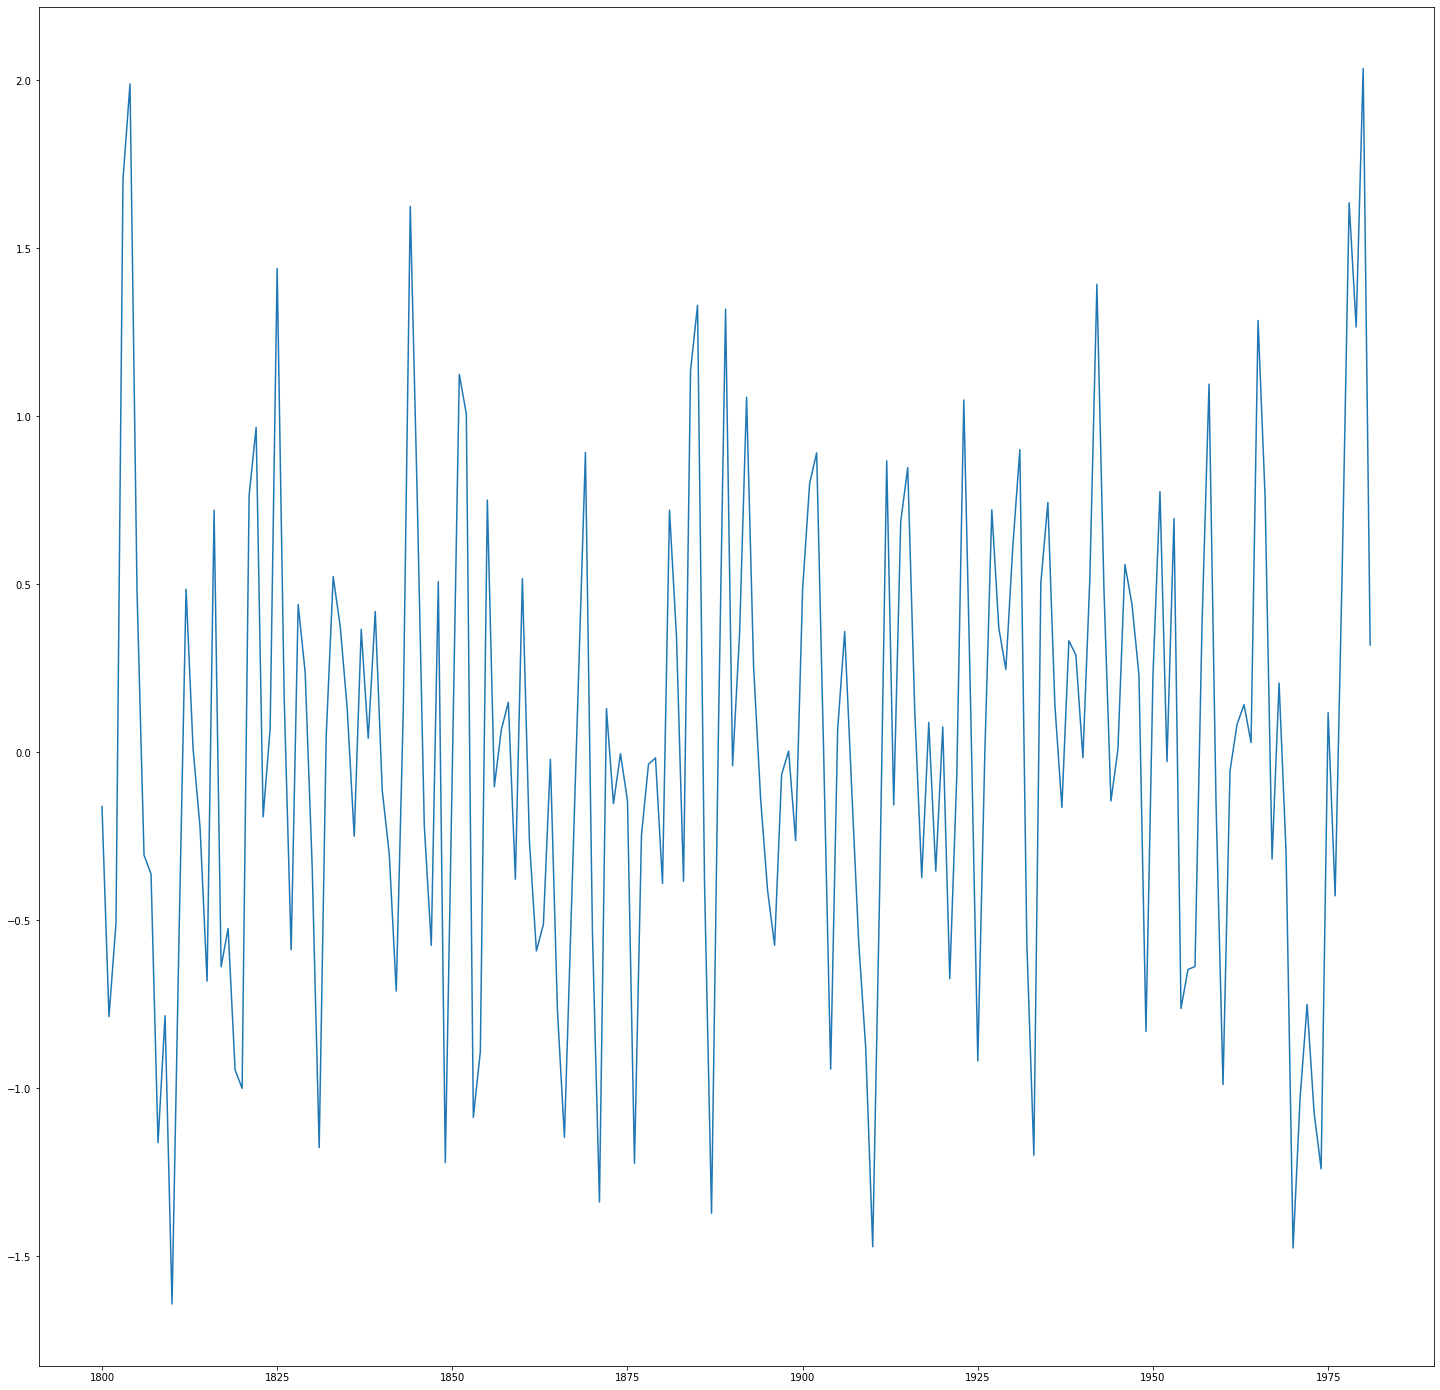

In [50]:
# This section deals with the parametes that will be used

SecStart = time.time()
SecName = "Parameters"

# Parameters
NN_Variable = 'scPDSI'

# This geos ahead and uses the stands or tree chronologies most correlated
# to the scPDSI over the training period as the inputs for the NN 
NN_UseSameInputMLR = 0

# Are we distribution matching in the end (over the training period)?
NN_DoDistributionMatch = 0

# Uncertain if only removing mean is enough (seeing as though the activation function is a leaky ReLU)
# If the following is 1, the output will be standardized prior to training (PCA and NN)
NN_StandardizeBeforeMethod = 1

# Are you allowing for multiple stand chronologies from the same site to enter?
NN_AllowDuplicateStands = True

# Time and Space Constraints
# Cook et al (1999)
NN_CaliYearMin = 1928
NN_CaliYearMax = 1978
NN_ValiYearMin = 1890
NN_ValiYearMax = 1927

# Actual Tree years that will be used
NN_TreeYearMin = 1800
NN_TreeYearMax = 1980

# Lat-Lon limitations of site and trees
NN_LatMax = 50
NN_LatMin = 25
NN_LonMax = -60
NN_LonMin = -130

# Allowing for stands a bit further away than the constraints of sites
NN_LatDeltaTree = 10
NN_LonDeltaTree = 10

# From the Clim Data (look at climate data for this)
NN_ClimYearMin = 1850
NN_ClimYearMax = 2014

# The actual analysis years
NN_ClimYearAnaMin = 1890
NN_ClimYearAnaMax = 1978

# Months (inclusive) that will be looked at for clim (averaged over these months)
NN_ClimMonthMin = 6
NN_ClimMonthMax = 8

# AR PROCESS
NN_ARTimeDelta = 3

# Do not want n in AR(n) to be larger than ARPMax
NN_ARPMin = 1
NN_ARPMax = 12

# These are the years that will be looked at for the overlap of instrumental and stands
# The AR_TimeDelta is considered later (removing the initial years)
NN_YearMin = np.min([NN_CaliYearMin,NN_ValiYearMin])#-NN_ARTimeDelta, considerado en "Load Climate"
NN_YearMax = np.max([NN_CaliYearMax,NN_ValiYearMax])

# The minimum number of stands that will be used. 
NN_MinTrees = 50

# Maximum distance of stands to site, Cook et al (1999) uses 450km for example
# if MaxDist == 0, will use the MinTrees number of closest stands
NN_MaxDist = 0 #(km) 

# Actual max distance to look at if MinTrees is used
NN_MaxDistConstraint = 450000

# NEURAL NETWORK

# If UseAdaptiveNumNodes == 0, then define the architecture. 
NN_HiddenNodes = 20

# Training epochs
NN_TrainEpochs = 50

# Activation function of choice
NN_Activation = 'keras.layers.LeakyReLU(alpha=0.3)' #.3Make sure this is. a string argument -- using evals statements

# Statement regarding the activation function
NN_ActivationStatement = 'LeakyReLU'#'ReLu'#'LeakyReLU'

# Regularization used?
NN_RegType = 'l2'

# If DropoutMod is 1, dropout is applied to every layer, otherwise, every n layers
NN_DropoutMod = 1 # before adding, this was 2

# Use a Dropout layer in the input layer?
NN_DropoutInput = 0

# If early stopping is used. 
NN_UseEarlyStopping = 0
NN_EarlyStoppingPatience = 2


# Changin the variable names IF NOT IMPORTING PARAMETERS
if ImportParams == 0 or TestingCode == 1 :
    NN_TestLayers = np.array([2])
    NN_TestRegWeight = copy.deepcopy(np.array([1.3]))
    NN_TestDropout = copy.deepcopy(np.array([0.0]))
    NN_TestRandTimes = (10+np.cumsum(np.ones(1))).astype(int)
    NN_TestRandPropTrain = np.array([.58])#.573
    NN_TestDOFPropToUse = copy.deepcopy(np.array([0.5]))


# IF IMPORTING PARAMETERS, THESE ARE USED     
else:
    # Where the imput parameters are 
    DataFileSource = DownloadLocation
    
    # Loading the file
    DataFile = scio.loadmat(DataFileSource) 
    
    # Number of laters
    NN_TestLayers = DataFile['NN_TestLayers'][OdysseyIndex,:].astype(int)
    
    # Weights of regularization
    NN_TestRegWeight = DataFile['NN_TestRegWeight'][OdysseyIndex,:]
    
    # Dropout used
    NN_TestDropout = DataFile['NN_TestDropout'][OdysseyIndex,:]
    
    # Random numbers used to initiate the randomized testing/training
    NN_TestRandTimes = DataFile['NN_TestRandTimes'][0,:].astype(int)
    
    # proportion of testing years that will be used. CAREFUL HERE. 
    NN_TestRandPropTrain = DataFile['NN_TestRandPropTrain'][OdysseyIndex,:]
    
    # Proportion of stand-year combos that are used to define architecture
    NN_TestDOFPropToUse = DataFile['NN_TestDOFProp'][OdysseyIndex,:]

    # Loading the description of test
    text = DataFile['Description'][0]
    


#Defined by Cook et al 1999 (for the correlation)
MLR_AlphaVal = 0.1

print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))


# Initiating some variables
NN_TestSkillRc2 = []
NN_TestSkillRv2 = []
NN_TestSkillRE = []
NN_TestSkillCE = []
NN_TestDataSplit = []
NN_TestReconClim = []
NN_TestClimClim = []
NN_TestRegUsed = []
NN_TestDrpUsed = []
NN_TestLayUsed = []
NN_TestRndUsed = []
NN_TestPrpUsed = []
NN_TestDOFUsed = []
MLR_TestSkillRc2 = []
MLR_TestSkillRv2 = []
MLR_TestSkillRE = []
MLR_TestSkillCE = []
MLR_TestReconClim = []

# Keeping track of how many times this is running
InterCountTestingAll = 0

# for every random number initor
for iTestRnd in range(len(NN_TestRandTimes)):
    
    # For every regweight used. 
    for iTestReg in range(len(NN_TestRegWeight)):
        
        # Load random number seed
        NN_SeedNo = copy.deepcopy(NN_TestRandTimes[iTestRnd])
        
        # Load these other vars
        NN_HiddenLayers = copy.deepcopy(NN_TestLayers[iTestReg])
        NN_RegWeight = copy.deepcopy(NN_TestRegWeight[iTestReg])
        NN_Dropout = copy.deepcopy(NN_TestDropout[iTestReg])
        NN_UseRandTrainTest = copy.deepcopy(NN_TestRandPropTrain[iTestReg])
        NN_UseAdaptiveNumNodes = copy.deepcopy(NN_TestDOFPropToUse[iTestReg])
        PrelimSeries = np.arange(NN_ClimYearAnaMax-NN_ClimYearAnaMin+1)
        
        # Careful with the "train_test_split" function, possibly cuts off/rounds percentages for test/train to some sigfigs
        # If used as a fraction (ie NumYearsTest/TotOverlapYears) the following is useful
        NN_UseRandTrainTest = np.ceil(NN_UseRandTrainTest*1000000)/1000000.
        
        # Track which years are used for what with the random state used. 
        Prelim_tr, Prelim_va, Prelim_tr, Prelim_va = train_test_split(PrelimSeries,
                                                                      PrelimSeries, 
                                                                      test_size=1-NN_UseRandTrainTest, 
                                                                      random_state=NN_SeedNo)
        
        # set seed (in case both of these are used differently )
        seed(NN_SeedNo)
        set_random_seed(NN_SeedNo)
            
        
        # Loading climate
        SecStart = time.time()
        SecName = "Load Data: Climate"
        
        
        NN_ClimFile = nc4.Dataset(NN_ClimFileSou,'r')
        #Format expressed here, in the case of PDSI, it is pdsi(time, lat, lon)
        
        # If confused as to how variables look, uncomment following
        #print(ClimFile.variables)
        
        # Load the variables
        NN_ClimVar = NN_ClimFile.variables['pdsi'][:,:,:]
        NN_ClimLat = NN_ClimFile.variables['lat'][:]
        NN_ClimLon = NN_ClimFile.variables['lon'][:]
        
        
        # Careful with how the NaNs are defined. 
        NN_ClimVar[NN_ClimVar <= -9999] = np.nan
        
        # Making the arrays for the used climate data
        NN_ClimLimData = np.zeros((NN_YearMax-NN_YearMin+1+NN_ARTimeDelta,0))
        NN_ClimLimLon = np.zeros((0,1))
        NN_ClimLimLat = np.zeros((0,1))
        
        
        
        # A counter
        InterCount = 0
        
        # Making the climate data files 
        for i in range(len(NN_ClimLat)):
            for j in range(len(NN_ClimLon)):
                
                # checking whether the lat-lon are on land and within the limits of lat and lon
                if (is_land(NN_ClimLon[j],NN_ClimLat[i]) and NN_ClimLat[i]>=NN_LatMin and NN_ClimLat[i]<=NN_LatMax and 
                    NN_ClimLon[j]>=NN_LonMin and NN_ClimLon[j]<=NN_LonMax and 
                    # checking for no nans over the period of interest (using mask or using nan)
                    np.sum(np.isnan(NN_ClimVar[(NN_YearMin-NN_ClimYearMin)*12:(NN_YearMax-NN_ClimYearMin+1)*12,i,j]))==0): 
                    
                    # this assumes that the climate data is in months
                    InterClim = np.array(NN_ClimVar[(NN_YearMin-NN_ClimYearMin-NN_ARTimeDelta)*12:(NN_YearMax-NN_ClimYearMin+1)*12,i,j].reshape(-1,12))
                    
                    # taking the mean over the months of interest. Changed this recently -- used to not account for the indexing in zero 
                    InterClim = np.nanmean(InterClim[:,NN_ClimMonthMin-1:NN_ClimMonthMax],1) 
                    # InterClim = np.nanmean(InterClim[:,NN_ClimMonthMin:NN_ClimMonthMax],1)  # This was a recent error change -- paper uses this one.
                    
                    # Making the data arrays that are used. 
                    NN_ClimLimData = np.concatenate((NN_ClimLimData,InterClim.reshape(-1,1)),axis=1)
                    NN_ClimLimLon = np.concatenate((NN_ClimLimLon,NN_ClimLon[j].reshape(-1,1)),axis=0)
                    NN_ClimLimLat = np.concatenate((NN_ClimLimLat,NN_ClimLat[i].reshape(-1,1)),axis=0)
                    
                    # CHECK HERE
                    # Counting number of sites (print if want to know)
                    InterCount = InterCount+1

        NN_ClimDataToStat =  copy.deepcopy(NN_ClimLimData[NN_ARTimeDelta:,:] )          
        print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))

        # Raw data that will be used. 
        NN_TreeLimData = np.zeros((NN_TreeYearMax-NN_TreeYearMin+2,0))
        NN_TreeLimLon = np.zeros((0,1))
        NN_TreeLimLat = np.zeros((0,1))
        NN_TreeSite = []

        TreeFile = scio.loadmat(TreeFileSource);

        TreeARSTAN = mat['NN_Tree_Data'] # if using scipy.io.loadmat
        
        
        # your chon means
        # data is transformed to [chon, years]
        TreeChron = np.transpose(TreeARSTAN['chron_mean'][0,0])
        
        # your stand lat and lon
        TreeLat = TreeARSTAN['latitude'][0,0].reshape(-1)
        TreeLon = TreeARSTAN['longitude'][0,0].reshape(-1)
    
        # If you are screening the stands for repeat chrons, will use first one that appears, load their sitename
        TreeFile_SiteName = TreeARSTAN['sitename'][0,0].reshape(-1)
        
        # counting stands
        InterCount = 0            
        for i in range(len(TreeLat)):
            
            # Making sure that there is data when and where needed
            if (TreeLat[i]>=NN_LatMin-NN_LatDeltaTree and TreeLat[i]<=NN_LatMax+NN_LatDeltaTree and 
                TreeLon[i]>=NN_LonMin-NN_LonDeltaTree and TreeLon[i]<=NN_LonMax+NN_LonDeltaTree and 
                # one year lagged chrons are used, the extra year is just for protection, checking for nans here
                np.sum(np.isnan(TreeChron[i,NN_TreeYearMin-NN_TreeYearMin:int(NN_TreeYearMax-NN_TreeYearMin+2)]))==0):
                
                # Need to check if repeated site:              
                str1 = TreeFile_SiteName[i][0]
                
                # Only use one if duplicate stands are used
                if NN_AllowDuplicateStands:
                     # storing the TreeSite name
                    NN_TreeSite.append(str1)
                    
                    InterTree = np.array(TreeChron[i,NN_TreeYearMin-NN_TreeYearMin:int(NN_TreeYearMax-NN_TreeYearMin+2)])
                    NN_TreeLimData = np.concatenate((NN_TreeLimData,InterTree.reshape(-1,1)),axis=1)
                    NN_TreeLimLon = np.concatenate((NN_TreeLimLon,TreeLon[i].reshape(-1,1)),axis=0)
                    NN_TreeLimLat = np.concatenate((NN_TreeLimLat,TreeLat[i].reshape(-1,1)),axis=0)
                    
                    # counting number of stands (print this if you want to know how many have been added)
                    InterCount = InterCount+1
                    
                elif str1 not in NN_TreeSite:
                    
                    # storing the TreeSite name
                    NN_TreeSite.append(str1)
                    
                    InterTree = np.array(TreeChron[i,NN_TreeYearMin-NN_TreeYearMin:int(NN_TreeYearMax-NN_TreeYearMin+2)])
                    NN_TreeLimData = np.concatenate((NN_TreeLimData,InterTree.reshape(-1,1)),axis=1)
                    NN_TreeLimLon = np.concatenate((NN_TreeLimLon,TreeLon[i].reshape(-1,1)),axis=0)
                    NN_TreeLimLat = np.concatenate((NN_TreeLimLat,TreeLat[i].reshape(-1,1)),axis=0)
                    
                    # counting number of stands (print this if you want to know how many have been added)
                    InterCount = InterCount+1


        print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))
        
        # printing the total number of stands
        print(str(np.shape(NN_TreeLimData)[1]) + ' trees were found')


        SecStart = time.time()
        SecName = "Arrange Data: Trees for each Clim Gridpoint"

        # closest trees
        TreeNumClose = np.zeros(len(NN_ClimLimLat))
        
        # we will store the stands used for each site
        NN_ClimTreesVal = []
        NN_ClimTreesLat = []
        NN_ClimTreesLon = []
        NN_ClimTreesInd = []
        
        # The distance of the farthest stand used for each site
        NN_ClimTreesMaxDistUsed = []
        for i in range(len(NN_ClimLimLat)):
            
            # distance of site to the stands
            InterDistance = Distance_Earth(NN_ClimLimLat[i]*np.ones(np.shape(NN_TreeLimLat.reshape(-1))),
                                                 NN_ClimLimLon[i]*np.ones(np.shape(NN_TreeLimLat.reshape(-1))),
                                                 NN_TreeLimLat.reshape(-1), NN_TreeLimLon.reshape(-1))
            
            # argument of sorted distance
            InterDistInd = np.argsort(Distance_Earth(NN_ClimLimLat[i]*np.ones(np.shape(NN_TreeLimLat)),
                                                 NN_ClimLimLon[i]*np.ones(np.shape(NN_TreeLimLat)),
                                                 NN_TreeLimLat, NN_TreeLimLon).reshape(-1))
            
            # finding the distance of the MinTrees stand
            InterDistMinTrees = np.sort(Distance_Earth(NN_ClimLimLat[i]*np.ones(np.shape(NN_TreeLimLat)),
                                                 NN_ClimLimLon[i]*np.ones(np.shape(NN_TreeLimLat)),
                                                 NN_TreeLimLat, NN_TreeLimLon).reshape(-1))[NN_MinTrees-1]
            
            # checking that the trees are within the absolute maximum distance constraint
            if InterDistMinTrees <= NN_MaxDistConstraint:
                
                # using the maximum number of trees between the ones within the Cook distance used and the MinTrees distance, basically
                # if there are two stands with the same distance as the MinTrees stand, then both are used. 
                InterNumTrees = np.max([np.sum(InterDistance<=NN_MaxDist),np.sum(InterDistance<=InterDistMinTrees)])
                
                # one year lagged chron stored
                InterArrayVal = np.zeros((np.shape(NN_TreeLimData)[0]-1,2*InterNumTrees))
                InterArrayLat = np.zeros((2*InterNumTrees))
                InterArrayLon = np.zeros((2*InterNumTrees))
                InterArrayInd = np.zeros((2*InterNumTrees))
                
                # storing the data
                for j in range(InterNumTrees):
                    
                    # storing the standardized stand value (assumes that they are the res/std, not the raw stand chronology)
                    InterArrayVal[:,j] = ((NN_TreeLimData[0:-1,InterDistInd[j]] - np.mean(NN_TreeLimData[0:-1,InterDistInd[j]]))/
                                          np.std(NN_TreeLimData[0:-1,InterDistInd[j]]))
                    InterArrayLat[j] = NN_TreeLimLat[InterDistInd[j]]
                    InterArrayLon[j] = NN_TreeLimLon[InterDistInd[j]]
                    InterArrayInd[j] = InterDistInd[j]
                    
                    # one year lagged chron added (climate this year can affect the tree next year)
                    InterArrayVal[:,InterNumTrees+j] = ((NN_TreeLimData[1:,InterDistInd[j]] - np.mean(NN_TreeLimData[1:,InterDistInd[j]]))/
                                                          np.std(NN_TreeLimData[1:,InterDistInd[j]]))
                    InterArrayLat[InterNumTrees+j] = NN_TreeLimLat[InterDistInd[j]]
                    InterArrayLon[InterNumTrees+j] = NN_TreeLimLon[InterDistInd[j]]
                    InterArrayInd[InterNumTrees+j] = InterDistInd[j]
                
                # appending these to the full record. 
                NN_ClimTreesVal.append(InterArrayVal)
                NN_ClimTreesLat.append(InterArrayLat)
                NN_ClimTreesLon.append(InterArrayLon)
                NN_ClimTreesInd.append(InterArrayInd)
                NN_ClimTreesMaxDistUsed.append(InterDistMinTrees)
                TreeNumClose[i] = np.shape(InterArrayVal)[1]
            
            # this site is basically not used, as the distance of the MinTree's stand is farther than absolute max distance
            else:

                NN_ClimTreesVal.append(np.zeros((np.shape(NN_TreeLimData)[0]-1,2*NN_MinTrees)))
                NN_ClimTreesLat.append(np.zeros((2*NN_MinTrees))*np.nan)
                NN_ClimTreesLon.append(np.zeros((2*NN_MinTrees))*np.nan)
                NN_ClimTreesInd.append(np.zeros((2*NN_MinTrees))*np.nan)
                TreeNumClose[i] = 2*NN_MinTrees      

        print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))

        # prewhitening and standardizing climate. 
        SecStart = time.time()
        SecName = "Data: Prewhiten and standardize climate"
        
        # AR refers to the prewhitening
        NN_ClimARData = np.zeros((np.shape(NN_ClimLimData)[0]-NN_ARTimeDelta,np.shape(NN_ClimLimData)[1]))
        NN_ClimARData.fill(np.nan)
        
        # the actual coefficients that are found
        NN_ClimARCoef = np.zeros((NN_ARPMax,np.shape(NN_ClimLimData)[1]))
        NN_ClimARCoef.fill(np.nan)
        
        # storing the mean and std of the climate over the training period, added back at the end
        NN_ClimARCaliMean = np.zeros(np.shape(NN_ClimLimLat))
        NN_ClimARCaliMean.fill(np.nan)
        NN_ClimARCaliStdev = np.zeros(np.shape(NN_ClimLimLat))
        NN_ClimARCaliStdev.fill(np.nan)

        # I love counting things, as has become obvious. 
        InterCount = 0
        for i in range(len(NN_ClimLimLat)):
            
            # AR of climate
            InterClimAR = AutoRegression(NN_ClimLimData[:,i], NN_ARPMin, NN_ARPMax, AICcOrBIC='AIC')
            
            # storing the prewhitened data (but avoiding first years)
            NN_ClimARData[:,i] = InterClimAR.ARTimeSeries[NN_ARTimeDelta:].reshape(-1)
            
            # storing the coefficients found
            NN_ClimARCoef[0:InterClimAR.ARP,i] = InterClimAR.ARCoefs.reshape(-1)
            
            # if randomized training and testing
            if NN_UseRandTrainTest != 0:
                clim_tr, clim_va, clim_tr, clim_va = train_test_split(NN_ClimARData[:,i],
                                                          NN_ClimARData[:,i], 
                                                          test_size=1-NN_UseRandTrainTest, random_state=NN_SeedNo)
                NN_ClimARCaliMean[i] = np.mean(clim_tr.reshape(-1))
                NN_ClimARCaliStdev[i] = np.std(clim_tr.reshape(-1))
            # if not using randomized training and testing, I personally do not like this, results can be contingent on combo of years used. 
            else:
                NN_ClimARCaliMean[i] = np.mean(NN_ClimARData[NN_CaliYearMin-NN_YearMin:NN_CaliYearMax-NN_YearMin+1,i].reshape(-1))
                NN_ClimARCaliStdev[i] = np.std(NN_ClimARData[NN_CaliYearMin-NN_YearMin:NN_CaliYearMax-NN_YearMin+1,i].reshape(-1))
            
            # count count count
            InterCount = InterCount+1    

        # standardizing the result. 
        if NN_StandardizeBeforeMethod:
            NN_ClimARStd = np.multiply(NN_ClimARData-np.tile(NN_ClimARCaliMean.reshape(1,-1),(NN_YearMax-NN_YearMin+1,1)),
                                        1./np.tile(NN_ClimARCaliStdev.reshape(1,-1),(NN_YearMax-NN_YearMin+1,1)))
        else:
            NN_ClimARStd = NN_ClimARData
            NN_ClimARCaliMean = np.zeros(np.shape(NN_ClimARCaliMean))
            NN_ClimARCaliStdev = np.ones(np.shape(NN_ClimARCaliStdev))
            

        print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName)) 


        # # Neural Network Start


        SecStart = time.time()

        SecName = "Neural Nets Start"
        

        # WOOOOOHOOO STARTING NN and PCA
        NN_NNModels = []
        if NN_UseRandTrainTest ==0:
            
            # training record (calibration)
            NN_ReconClimARStdCali = np.zeros((NN_CaliYearMax - NN_CaliYearMin + 1, len(NN_ClimTreesVal)))
            NN_ReconClimARStdCali.fill(np.nan)
            
            # testing record (validation)
            NN_ReconClimARStdVali = np.zeros((NN_ValiYearMax - NN_ValiYearMin + 1, len(NN_ClimTreesVal)))
            NN_ReconClimARStdVali.fill(np.nan)
            
        else:
            
            # size of training and testing being defined. (CHECK THIS IN CASE THERE WAS A ROUNDING ERROR)
            y = NN_ClimARStd[:,0].reshape(-1,1)
            x = NN_ClimTreesVal[0][NN_YearMin-NN_TreeYearMin:NN_YearMax-NN_TreeYearMin+1,:]
            x_tr, x_va, y_tr, y_va = train_test_split(x, y, test_size=1-NN_UseRandTrainTest, random_state=NN_SeedNo) #42

            # same as before
            NN_ReconClimARStdCali = np.zeros((len(y_tr), len(NN_ClimTreesVal)))
            NN_ReconClimARStdCali.fill(np.nan)
            NN_ReconClimARStdVali = np.zeros((len(y_va), len(NN_ClimTreesVal)))
            NN_ReconClimARStdVali.fill(np.nan)

        # full record
        NN_ReconClimARStdTotal = np.zeros((np.shape(NN_ClimTreesVal[1])[0],len(NN_ClimTreesVal)))
        NN_ReconClimARStdTotal.fill(np.nan)

        # climate range reconstruction
        NN_ReconClimARStdClimRange = np.zeros(np.shape(NN_ClimARStd))
        NN_ReconClimARStdClimRange.fill(np.nan)


        
        # FOR PCA (MLR here)
        MLR_ReconTreesUsed = np.zeros(len(NN_ClimLimLat))
        MLR_ReconTreesUsed.fill(np.nan)
        MLR_ReconCoefs = []
        
        # Same as NN but for MLR/PCA
        MLR_ReconClimARCaliStd = np.zeros(np.shape(NN_ReconClimARStdCali))
        MLR_ReconClimARCaliStd.fill(np.nan)
        MLR_ReconClimARValiStd = np.zeros(np.shape(NN_ReconClimARStdVali))
        MLR_ReconClimARValiStd.fill(np.nan)
        MLR_ReconClimARTotalStd = np.zeros(np.shape(NN_ReconClimARStdTotal))
        MLR_ReconClimARTotalStd.fill(np.nan)
        MLR_ReconClimARClimRangeStd = np.zeros(np.shape(NN_ClimARStd))
        MLR_ReconClimARClimRangeStd.fill(np.nan)
        
        # Eigenvectors used (from Cook et al (1999))
        MLR_ReconTreeCorrEigVecUsed = np.zeros((len(NN_ClimLimLat),int(np.max(TreeNumClose)),np.shape(NN_ReconClimARStdCali)[0]))
        MLR_ReconTreeCorrEigVecUsed.fill(np.nan)
        
        # significantly correlated number of stands used for MLR 
        TreeGridCorrClose = np.zeros(len(NN_ClimLimLat))

        # storing results (at times, I love redundancy)
        NN_ClimMinTrees = []
        NN_ReconClimMinTrees = []
        NN_ClimMaxTrees = []
        NN_ReconClimMaxTrees = []
        
        # for sensitivity, nor used much Sprt = separate. , These are not saved if SaveBasicResults is 1
        NN_SensReconClimAllAdd_Sprt_Sens = []
        NN_SensReconClimAllAdd_Sprt_x = []
        NN_SensReconClimAllAdd_Sprt_y = []
        NN_SensReconClimAllAdd_Mean_Sens = []
        NN_SensReconClimAllAdd_Mean_x = []
        NN_SensReconClimAllAdd_Group_x = []
        NN_SensReconClimAllAdd_Group_y = []
        NN_SensReconClimAllAdd_Group_Same_x = []
        NN_SensReconClimAllAdd_Group_Same_y = []
        
        # used lat and lon for reconstruction
        NN_ReconClimTreesLatUsed = []
        NN_ReconClimTreesLonUsed = []

        # storing this just in case. 
        NN_HiddenNodesUsed = []

        # storing these just in case
        NN_DropoutUsed = []
        NN_RegWeightUsed = []    

        # Sort of like Count von Count (Sesame St)
        InterCount = 0
        
        # Correlation which is significant considering the years used for training
        MLR_SigCorrel = SigCorrel(np.shape(NN_ReconClimARStdCali)[0]-2, MLR_AlphaVal)
        for i in range(len(NN_ClimLimLat)):
            if NN_UseRandTrainTest == 0:
                # use defined intervals for train and test
                x_tr = NN_ClimTreesVal[i][NN_CaliYearMin-NN_TreeYearMin:NN_CaliYearMax-NN_TreeYearMin+1,:]
                y_tr = NN_ClimARStd[NN_CaliYearMin-NN_YearMin:NN_CaliYearMax-NN_YearMin+1,i].reshape(-1,1)
                x_va = NN_ClimTreesVal[i][NN_ValiYearMin-NN_TreeYearMin:NN_ValiYearMax-NN_TreeYearMin+1,:]
                y_va = NN_ClimARStd[NN_ValiYearMin-NN_ClimYearMin:NN_ValiYearMax-NN_ClimYearMin+1,i].reshape(-1,1)
                
            else:
                # random train test intervals
                y = NN_ClimARStd[:,i].reshape(-1,1)
                x = NN_ClimTreesVal[i][NN_YearMin-NN_TreeYearMin:NN_YearMax-NN_TreeYearMin+1,:]
                x_tr, x_va, y_tr, y_va = train_test_split(x, y, test_size=1-NN_UseRandTrainTest, random_state=NN_SeedNo) #Random before 42

            # lat and lon for the trees
            x_lat = NN_ClimTreesLat[i]
            x_lon = NN_ClimTreesLon[i]
            x_to = NN_ClimTreesVal[i]
            
            # only the range that you are comparing to the climate variable
            x_ClimRange = NN_ClimTreesVal[i][NN_YearMin-NN_TreeYearMin:NN_YearMax-NN_TreeYearMin+1,:]
            
            # making the arrays that will be filled
            MLR_x_tr = np.zeros(np.shape(x_tr))
            MLR_x_va = np.zeros(np.shape(x_va))
            MLR_x_to = np.zeros(np.shape(x_to))
            MLR_x_ClimRange = np.zeros(np.shape(x_ClimRange))
            MLR_x_lat = np.zeros(np.shape(x_lat))
            MLR_x_lon = np.zeros(np.shape(x_lon))
            MLR_x_tr.fill(np.nan)
            MLR_x_va.fill(np.nan)
            MLR_x_to.fill(np.nan)
            MLR_x_ClimRange.fill(np.nan)
            MLR_x_lat.fill(np.nan)
            MLR_x_lon.fill(np.nan)
            
            #Level 2 of Cook et al: only those that are significantly correlated to scPDSI at the gridpoint will be kept
            InterCountCorr=0
            for jCorr in range(int(TreeNumClose[i])):
                if np.abs(np.corrcoef(x_tr[:,jCorr],y_tr.reshape(-1))[0,1]) >= MLR_SigCorrel:
                    MLR_x_tr[:,InterCountCorr] = x_tr[:,jCorr]
                    MLR_x_va[:,InterCountCorr] = x_va[:,jCorr]
                    MLR_x_to[:,InterCountCorr] = x_to[:,jCorr]
                    MLR_x_ClimRange[:,InterCountCorr] = x_ClimRange[:,jCorr]
                    MLR_x_lat[InterCountCorr] = NN_ClimTreesLat[i][jCorr]
                    MLR_x_lon[InterCountCorr] = NN_ClimTreesLon[i][jCorr]
                    InterCountCorr = InterCountCorr + 1      
            
            TreeGridCorrClose[i] = InterCountCorr
            MLR_x_tr = MLR_x_tr[:,0:InterCountCorr]
            MLR_x_va = MLR_x_va[:,0:InterCountCorr]
            MLR_x_to = MLR_x_to[:,0:InterCountCorr]
            MLR_x_ClimRange = MLR_x_ClimRange[:,0:InterCountCorr]
            MLR_x_lat = MLR_x_lat[0:InterCountCorr]
            MLR_x_lon = MLR_x_lon[0:InterCountCorr]
            
            # In order to use the same inputs in the NN as with the MLR 
            # (only the significantly correlated stands to target during train period. )
            if NN_UseSameInputMLR == 1:
                x_tr = copy.deepcopy(MLR_x_tr)
                x_va = copy.deepcopy(MLR_x_va)
                x_to = copy.deepcopy(MLR_x_to)
                x_ClimRange = copy.deepcopy(MLR_x_ClimRange)
                x = copy.deepcopy(MLR_x_ClimRange)
                x_lat = copy.deepcopy(MLR_x_lat)
                x_lon = copy.deepcopy(MLR_x_lon)
                
            
            # making sure that at least one stand chronology is correlated to the scPDSI
            if InterCountCorr > 0:
            
                # All of theis codfe is in the original MLR_NN code
                
                # Running the PCA (described in Cook et al (1999) if a reference is needed)
                MLR_TreeCaliForPCA = MLR_x_tr.T
                MLR_TreeCorrMatrix = np.corrcoef(MLR_TreeCaliForPCA,rowvar=True)
                if np.shape(MLR_TreeCorrMatrix) == ():
                    MLR_TreeCorrEigValMat, MLR_TreeCorrEigVecMat = np.linalg.eig(MLR_TreeCorrMatrix.reshape(-1,1))
                else:
                    MLR_TreeCorrEigValMat, MLR_TreeCorrEigVecMat = np.linalg.eig(MLR_TreeCorrMatrix)
               
                # Checking how many factors satisfy the Kaiser Guttman criterion (eigenvalue>=1)
                MLR_TreeKaisGutt = np.sum(MLR_TreeCorrEigValMat>=1)
                
                # sort in decreasing eigenvalue 
                MLR_TreeCorrEigVecSort = MLR_TreeCorrEigVecMat[:,np.argsort(-MLR_TreeCorrEigValMat)]
                
                # keeping only those that satisfy the criterion
                MLR_TreeCorrEigVecKG = MLR_TreeCorrEigVecSort[:,0:MLR_TreeKaisGutt]
                
                # calculating the scores
                MLR_TreeScores = np.dot(MLR_TreeCaliForPCA.T,MLR_TreeCorrEigVecKG)
                
                # making the array
                MLR_ClimCorrTreeScore = np.zeros(np.shape(MLR_TreeScores[1]))
                
                # need to find which scores are best correlated (in absolute value) to the target scPDSI
                for j in range(len(MLR_ClimCorrTreeScore)):
                    MLR_ClimCorrTreeScore[j] = np.abs(np.corrcoef(y_tr.reshape(-1),MLR_TreeScores[:,j])[0,1])
                
                # sorted by absolute correlation
                MLR_TreeScoresSort = MLR_TreeScores[:,np.argsort(-np.abs(MLR_ClimCorrTreeScore))]
                
                # storing the eigenvectors
                MLR_TreeCorrEigVecKGSort = MLR_TreeCorrEigVecKG[:,np.argsort(-np.abs(MLR_ClimCorrTreeScore))]
                
                # regression using the AICc criterion
                MLR_ReconClimCali, MLR_ReconClimBetaCoef, MLR_ReconCaliAICcMin = RegressAICc(np.real(MLR_TreeScoresSort),
                                                                                                     np.real(y_tr).reshape(-1))
                
                # storing how many are used
                MLR_ReconTreesUsed[i] = MLR_ReconCaliAICcMin
                
                # storing the coefficients
                MLR_ReconCoefs.append(MLR_ReconClimBetaCoef.reshape(-1))
                
                # Storing the AR Std calibration reconstruction
                MLR_ReconClimARCaliStd[:,i] = MLR_ReconClimCali.reshape(-1)
                
                # storing the eigvecs used
                MLR_ReconTreeCorrEigVecUsed[i,0:int(TreeGridCorrClose[i]),0:int(MLR_ReconCaliAICcMin)] = MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin]
                
                # regression for testing
                MLR_ReconClimARValiStd[:,i] = np.dot(np.dot(MLR_x_va,
                                                        MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin]),
                                                 MLR_ReconClimBetaCoef.reshape(-1,1)).reshape(-1)
                
                # full regression (full in terms of stands)
                MLR_ReconClimARTotalStd[:,i] = np.dot(np.dot(MLR_x_to,
                                                         MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin]),
                                                  MLR_ReconClimBetaCoef.reshape(-1,1)).reshape(-1)
                
                # climate range regression
                MLR_ReconClimARClimRangeStd[:,i] = np.dot(np.dot(MLR_x_ClimRange,
                                                                 MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin]),
                                                          MLR_ReconClimBetaCoef.reshape(-1,1)).reshape(-1)
                
                # Storing the relevant scores
                MLR_TreeScoresCali = np.dot(MLR_x_tr,MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin])
                MLR_TreeScoresVali = np.dot(MLR_x_va,MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin])
                MLR_TreeScoresTotal = np.dot(MLR_x_to,MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin])
                MLR_TreeScoresClimRange = np.dot(MLR_x_ClimRange,MLR_TreeCorrEigVecKGSort[:,0:MLR_ReconCaliAICcMin])

            
            # To make sure that it is valid to perform the NN -- cosidering the NN_UseSameInputMLR
            # basically to make sure that there are enough stands to perform NN
            if NN_UseSameInputMLR == 1:
                
                if InterCountCorr > 0:
                    IndexCondition = 1
                else:
                    IndexCondition = 0
            else: 
                IndexCondition = 1
            if IndexCondition == 1:
                
                # making the architecture of the NN be made depending on the data available 
                # basically the number of fitted parameters is a function of the stand-year data amount 
                # so as to not have more coefficients fit than data available, 
                # depends on NN_UseAdaptiveNumNodes (proportion of data number used)
                if NN_UseAdaptiveNumNodes != 0:
                    
                    NN_HiddenNodes = int(np.floor(np.max(np.roots([NN_HiddenLayers-1,
                                                                   np.shape(x_tr)[1]+1+NN_HiddenLayers,
                                                                   1-(np.shape(x_tr)[1])*(np.shape(x_tr)[0])*NN_UseAdaptiveNumNodes]))))
                # Storing the number of nodes
                NN_HiddenNodesUsed.append(NN_HiddenNodes)
                
                # Storing the regularization
                NN_DropoutUsed.append(NN_Dropout)
                NN_RegWeightUsed.append(NN_RegWeight)
                
                # parameters used for the NN
                NN_Params = [NN_HiddenLayers,NN_HiddenNodes,NN_Activation,NN_RegWeight,[NN_DropoutInput,NN_Dropout,NN_DropoutMod],NN_TrainEpochs]
                
                # WOOOOOHOOOO NN USED. 
                Model_Results = NN_Calc(x_tr,y_tr,x_va,x_to,x_ClimRange,NN_Params)
    
     
            # this is the output
            #     NN_Calc returns: [Model, #0
            #             y_ReconTr, #1
            #             y_ReconVa, #2 
            #             y_ReconTo, #3
            #             y_ReconOther, #4
            #             NN_Sens_Group, #5
            #             NN_Sens_Indiv_Mean, #6
            #             NN_Sens_Indiv_Sprt, #7
            #.            NN_Sens_Group_Same] #8
                
            # Save the model? Uses some storage. 
            if NN_SaveModels == 1: 
                Model = Model_Results[0]
                InterTime = copy.deepcopy(dt.datetime.now().strftime("%Y%m%d-%H")[2:]) #this in order to avoid changes in hour between the saves. 
                Model.save('./Results/Python/NNTrees/Models/'+
                           InterTime+'_NNModel_GridPoint-'+str(int(i))+'_Rnd-'+str(iTestRnd)+'_Reg-'+str(iTestReg)+'.h5')
                NN_NNModels.append('./Results/Python/NNTrees/Models/'+
                           InterTime+'_NNModel_GridPoint-'+str(int(i))+'_Rnd-'+str(iTestRnd)+'_Reg-'+str(iTestReg)+'.h5')
                Model.save('./Results/Python/NNTrees/Models/'+
                           'NNModel_GridPoint-'+str(int(i))+'_Rnd-'+str(iTestRnd)+'_Reg-'+str(iTestReg)+'.h5') 

                Model_yaml = Model.to_yaml()
                with open('./Results/Python/NNTrees/Models/'+
                           InterTime+'_YAML-NNModel_GridPoint-'+str(int(i))+'_Rnd-'+str(iTestRnd)+'_Reg-'+str(iTestReg)+'.yaml', "w") as yaml_file:
                    yaml_file.write(Model_yaml)    
            
            # the predictions for the total, the train, the test, and theother range. 
            NN_ReconClimARStdTotal[:,i] = Model_Results[3].reshape(-1)#Y_ReconTot.reshape(-1)
            NN_ReconClimARStdCali[:,i] = Model_Results[1].reshape(-1)#Y_ReconCali.reshape(-1)
            NN_ReconClimARStdVali[:,i] = Model_Results[2].reshape(-1)#Y_ReconVali.reshape(-1)
            NN_ReconClimARStdClimRange[:,i] = Model_Results[4].reshape(-1)#Y_ReconTot[NN_YearMin - NN_TreeYearMin: NN_YearMax - NN_TreeYearMin + 1,0].reshape(-1)
            
            # Each tree is perturbes separately and the Delta target is recorded, ad well as the background target 
            NN_SensReconClimAllAdd_Sprt_Sens.append(Model_Results[7][1])
            NN_SensReconClimAllAdd_Sprt_x.append(Model_Results[7][0])
            NN_SensReconClimAllAdd_Sprt_y.append(Model_Results[7][2])
            
            # Each tree goes through its range of growth andthe rest of the stands are kept at their mean.
            NN_SensReconClimAllAdd_Mean_Sens.append(Model_Results[6][1])
            NN_SensReconClimAllAdd_Mean_x.append(Model_Results[6][0])
            
            # All trees are input sorted by their ARSTAN growth 
            NN_SensReconClimAllAdd_Group_x.append(Model_Results[5][0])
            NN_SensReconClimAllAdd_Group_y.append(Model_Results[5][1])
            
            NN_SensReconClimAllAdd_Group_Same_x.append(Model_Results[8][0])
            NN_SensReconClimAllAdd_Group_Same_y.append(Model_Results[8][1])
            
            # lat on of. thestands used or the sensitivity analysis
            NN_ReconClimTreesLatUsed.append(x_lat)
            NN_ReconClimTreesLonUsed.append(x_lon)

            InterCount = InterCount+1    
            if InterCount%5 == 0:
                print("%s seconds to run %s of %s places" % (round(time.time() - SecStart,4),str(InterCount),str(len(NN_ClimLimLat))))
     

        if NN_StandardizeBeforeMethod:
            # Storing all of the results (Train, test, total, climate range) adding back the calibration stdev and mean
            #  This assumes that the output has zero mean, for example, which might not be true. 
            NN_ReconClimARCali = copy.deepcopy((np.multiply(NN_ReconClimARStdCali,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(len(x_tr),1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(len(x_tr),1))))
            NN_ReconClimARVali = copy.deepcopy((np.multiply(NN_ReconClimARStdVali,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(len(x_va),1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(len(x_va),1))))
            NN_ReconClimARTotal = copy.deepcopy((np.multiply(NN_ReconClimARStdTotal,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(np.shape(NN_ClimTreesVal[1])[0],1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(np.shape(NN_ClimTreesVal[1])[0],1))))
            NN_ReconClimARClimRange = copy.deepcopy((np.multiply(NN_ReconClimARStdClimRange,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(np.shape(NN_ReconClimARStdClimRange)[0],1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(np.shape(NN_ReconClimARStdClimRange)[0],1))))

            # Storing the MLR equivalents.
            MLR_ReconClimARCali = copy.deepcopy((np.multiply(MLR_ReconClimARCaliStd,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(len(x_tr),1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(len(x_tr),1))))
            MLR_ReconClimARVali = copy.deepcopy((np.multiply(MLR_ReconClimARValiStd,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(len(x_va),1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(len(x_va),1))))
            MLR_ReconClimARTotal = copy.deepcopy((np.multiply(MLR_ReconClimARTotalStd,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(np.shape(NN_ClimTreesVal[1])[0],1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(np.shape(NN_ClimTreesVal[1])[0],1))))
            MLR_ReconClimARClimRange = copy.deepcopy((np.multiply(MLR_ReconClimARClimRangeStd,np.tile(NN_ClimARCaliStdev.reshape(1,-1),(np.shape(NN_ReconClimARStdClimRange)[0],1)))+
                               np.tile(NN_ClimARCaliMean.reshape(1,-1),(np.shape(NN_ReconClimARStdClimRange)[0],1))))
        else:
            
            NN_ReconClimARCali = copy.deepcopy(NN_ReconClimARStdCali)
            NN_ReconClimARVali = copy.deepcopy(NN_ReconClimARStdVali)
            NN_ReconClimARTotal = copy.deepcopy(NN_ReconClimARStdTotal)
            NN_ReconClimARClimRange = copy.deepcopy(NN_ReconClimARStdClimRange)

            # Storing the MLR equivalents.
            MLR_ReconClimARCali = copy.deepcopy(MLR_ReconClimARCaliStd)
            MLR_ReconClimARVali = copy.deepcopy(MLR_ReconClimARValiStd)
            MLR_ReconClimARTotal = copy.deepcopy(MLR_ReconClimARTotalStd)
            MLR_ReconClimARClimRange = copy.deepcopy(MLR_ReconClimARClimRangeStd)

        NN_ReconClimCali = np.zeros(np.shape(NN_ReconClimARCali))
        NN_ReconClimVali = np.zeros(np.shape(NN_ReconClimARVali))
        NN_ClimDataCali = np.zeros(np.shape(NN_ReconClimARCali))
        NN_ClimDataVali = np.zeros(np.shape(NN_ReconClimARVali))
        NN_ReconClimCali.fill(np.nan)
        NN_ReconClimVali.fill(np.nan)
        NN_ClimDataCali.fill(np.nan)
        NN_ClimDataVali.fill(np.nan)


        NN_ReconClimTotal = np.zeros(np.shape(NN_ReconClimARTotal))
        NN_ReconClimTotal.fill(np.nan)
        
        MLR_ReconClimCali = np.zeros(np.shape(NN_ReconClimARCali))
        MLR_ReconClimVali = np.zeros(np.shape(NN_ReconClimARVali))
        MLR_ReconClimCali.fill(np.nan)
        MLR_ReconClimVali.fill(np.nan)
        MLR_ReconClimTotal = np.zeros(np.shape(NN_ReconClimARTotal))
        MLR_ReconClimTotal.fill(np.nan)

        # Adding back the redness that was removed from climate
        for i in range(len(NN_ClimLimLat)):
            NN_InterTimeSeries = copy.deepcopy(NN_ReconClimARTotal[:,i].reshape(-1,1))
            MLR_InterTimeSeries = copy.deepcopy(MLR_ReconClimARTotal[:,i].reshape(-1,1))
            NN_ReconClimTotal[:,i] = InvAR(NN_InterTimeSeries,NN_ClimARCoef[0:np.sum(~np.isnan(NN_ClimARCoef[:,i])),i]).reshape(-1)
            MLR_ReconClimTotal[:,i] = InvAR(MLR_InterTimeSeries,NN_ClimARCoef[0:np.sum(~np.isnan(NN_ClimARCoef[:,i])),i]).reshape(-1)
            
            # getting the training and testing considering the redness
            if NN_UseRandTrainTest != 0:
                NN_climrec_tr, NN_climrec_va, clim_tr, clim_va = train_test_split(NN_ReconClimTotal[NN_YearMin - NN_TreeYearMin:NN_YearMax - NN_TreeYearMin+1,i],
                                                       NN_ClimDataToStat[:,i], 
                                                       test_size=1-NN_UseRandTrainTest, random_state=NN_SeedNo)
                MLR_climrec_tr, MLR_climrec_va, clim_tr, clim_va = train_test_split(MLR_ReconClimTotal[NN_YearMin - NN_TreeYearMin:NN_YearMax - NN_TreeYearMin+1,i],
                                                       NN_ClimDataToStat[:,i], 
                                                       test_size=1-NN_UseRandTrainTest, random_state=NN_SeedNo)
                NN_ReconClimCali[:,i] = NN_climrec_tr
                NN_ReconClimVali[:,i] = NN_climrec_va
                MLR_ReconClimCali[:,i] = MLR_climrec_tr
                MLR_ReconClimVali[:,i] = MLR_climrec_va
                NN_ClimDataCali[:,i] = clim_tr
                NN_ClimDataVali[:,i] = clim_va


        if NN_UseRandTrainTest == 0:
            NN_ReconClimCali = NN_ReconClimTotal[NN_CaliYearMin-NN_TreeYearMin:NN_CaliYearMax-NN_TreeYearMin+1,:]
            NN_ReconClimVali = NN_ReconClimTotal[NN_ValiYearMin-NN_TreeYearMin:NN_ValiYearMax-NN_TreeYearMin+1,:]
            MLR_ReconClimCali = MLR_ReconClimTotal[NN_CaliYearMin-NN_TreeYearMin:NN_CaliYearMax-NN_TreeYearMin+1,:]
            MLR_ReconClimVali = MLR_ReconClimTotal[NN_ValiYearMin-NN_TreeYearMin:NN_ValiYearMax-NN_TreeYearMin+1,:]
            NN_ClimDataCali = NN_ClimDataToStat[NN_CaliYearMin-NN_YearMin:NN_CaliYearMax-NN_YearMin+1,:]
            NN_ClimDataVali = NN_ClimDataToStat[NN_ValiYearMin-NN_YearMin:NN_ValiYearMax-NN_YearMin+1,:]
        
        # climate range
        NN_ReconClimClimRange = NN_ReconClimTotal[NN_YearMin - NN_TreeYearMin:NN_YearMax - NN_TreeYearMin+1,:]
        MLR_ReconClimClimRange = MLR_ReconClimTotal[NN_YearMin - NN_TreeYearMin:NN_YearMax - NN_TreeYearMin+1,:]

            
        NN_ClimDataClimRange = copy.deepcopy(NN_ClimDataToStat)
        
        # Matching the outputs to the distribution of the training. 
        if NN_DoDistributionMatch == 1:
            
            # changes final distribution of reconstruction to match the first two moments of the climate
            # training. This could be a bit dangerous, fixing the variance damping. 
            
            Clim_TrainMean = np.tile(np.mean(NN_ClimDataCali,axis = 0).reshape(1,-1),(np.shape(NN_ClimDataCali)[0],1))
            Clim_TrainStdv = np.tile(np.std(NN_ClimDataCali,axis = 0).reshape(1,-1),(np.shape(NN_ClimDataCali)[0],1))
            
            NN_ReconClimCali = ChangeDist(NN_ReconClimCali,Clim_TrainMean,Clim_TrainStdv)
            NN_ReconClimVali = ChangeDist(NN_ReconClimVali,Clim_TrainMean,Clim_TrainStdv)
            NN_ReconClimClimRange = ChangeDist(NN_ReconClimClimRange,Clim_TrainMean,Clim_TrainStdv)
            NN_ReconClimTotal = ChangeDist(NN_ReconClimTotal,Clim_TrainMean,Clim_TrainStdv)
            
            MLR_ReconClimCali = ChangeDist(MLR_ReconClimCali,Clim_TrainMean,Clim_TrainStdv)
            MLR_ReconClimVali = ChangeDist(MLR_ReconClimVali,Clim_TrainMean,Clim_TrainStdv)
            MLR_ReconClimClimRange = ChangeDist(MLR_ReconClimClimRange,Clim_TrainMean,Clim_TrainStdv)
            MLR_ReconClimTotal = ChangeDist(MLR_ReconClimTotal,Clim_TrainMean,Clim_TrainStdv)
            

        print("%s seconds to run %s" % (round(time.time() - SecStart,4),SecName))  



        # reconstruction statistics for NN and MLR
        # average explained variance over the calibration period
        NN_Rc2 =1-np.multiply(np.sum(np.multiply(NN_ClimDataCali - NN_ReconClimCali,NN_ClimDataCali - NN_ReconClimCali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataCali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataCali)[0],1)),
                                                     NN_ClimDataCali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataCali)[0],1))),
                                         axis=0)).reshape(-1,1)
        
        # squared Pearson correlation over testing period
        NN_Rv2=np.multiply(np.multiply(np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                               NN_ReconClimVali-np.tile(np.mean(NN_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0),
                                       np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                               NN_ReconClimVali-np.tile(np.mean(NN_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0)),
                            1./np.multiply(np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                              NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0),
                                           np.sum(np.multiply(NN_ReconClimVali-np.tile(np.mean(NN_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                              NN_ReconClimVali-np.tile(np.mean(NN_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0)))
        
        # Reduction of error
        NN_RE = 1-np.multiply(np.sum(np.multiply(NN_ClimDataVali - NN_ReconClimVali,NN_ClimDataVali - NN_ReconClimVali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                     NN_ClimDataVali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),
                                         axis=0)).reshape(-1,1)
        
        # Coefficient of efficiency
        NN_CE = 1-np.multiply(np.sum(np.multiply(NN_ClimDataVali - NN_ReconClimVali,NN_ClimDataVali - NN_ReconClimVali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                     NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),
                                         axis=0)).reshape(-1,1)
        
        
        # same for MLR
        MLR_Rc2 =1-np.multiply(np.sum(np.multiply(NN_ClimDataCali - MLR_ReconClimCali,NN_ClimDataCali - MLR_ReconClimCali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataCali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataCali)[0],1)),
                                                     NN_ClimDataCali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataCali)[0],1))),
                                         axis=0)).reshape(-1,1)
        MLR_Rv2=np.multiply(np.multiply(np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                               MLR_ReconClimVali-np.tile(np.mean(MLR_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0),
                                       np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                               MLR_ReconClimVali-np.tile(np.mean(MLR_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0)),
                            1./np.multiply(np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                              NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0),
                                           np.sum(np.multiply(MLR_ReconClimVali-np.tile(np.mean(MLR_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                              MLR_ReconClimVali-np.tile(np.mean(MLR_ReconClimVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),axis=0)))
        MLR_RE = 1-np.multiply(np.sum(np.multiply(NN_ClimDataVali - MLR_ReconClimVali,NN_ClimDataVali - MLR_ReconClimVali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                     NN_ClimDataVali-np.tile(np.mean(NN_ClimDataCali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),
                                         axis=0)).reshape(-1,1)
        MLR_CE = 1-np.multiply(np.sum(np.multiply(NN_ClimDataVali - MLR_ReconClimVali,NN_ClimDataVali - MLR_ReconClimVali),axis=0),
                               1./np.sum(np.multiply(NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1)),
                                                     NN_ClimDataVali-np.tile(np.mean(NN_ClimDataVali,axis=0),(np.shape(NN_ClimDataVali)[0],1))),
                                         axis=0)).reshape(-1,1)


        # how many sites have skill accoring to CE in NN
        print(np.sum(NN_CE>0)/np.sum(~np.isnan(NN_CE)))

        CheckNumTrees = []
        for i in range(len(NN_ClimTreesVal)):
            CheckNumTrees.append(np.shape(NN_ClimTreesVal[i])[1])


        # check the maximum number of trees in a site amongst all of them
        InterMax = 0
        InterMax2 = 0
        for i in range(len(NN_ClimTreesVal)):
            if np.shape(NN_ClimTreesVal[i])[1] > InterMax:
                InterMax = np.shape(NN_ClimTreesVal[i])[1]
            if len(NN_ReconClimTreesLatUsed[i]) > InterMax2:
                InterMax2 = len(NN_ReconClimTreesLatUsed[i])
    
        # making an array of everything
        NN_ClimTreesValArray = np.zeros((len(NN_ClimTreesVal),np.shape(NN_ClimTreesVal[0])[0],InterMax))
        NN_ClimTreesValArray.fill(np.nan)

        NN_ClimTreesLatArray = np.zeros((len(NN_ClimTreesVal),InterMax))
        NN_ClimTreesLatArray.fill(np.nan)
        NN_ClimTreesLonArray = np.zeros((len(NN_ClimTreesVal),InterMax))
        NN_ClimTreesLonArray.fill(np.nan)
        NN_ClimTreesIndArray = np.zeros((len(NN_ClimTreesVal),InterMax))
        NN_ClimTreesIndArray.fill(np.nan)

        # Sensitivity
        NN_SensReconClimAllAdd_Sprt_Sens_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Sprt_x_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Sprt_y_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0]))
        NN_SensReconClimAllAdd_Mean_Sens_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Mean_x_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Group_x_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Group_y_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0]))
        NN_SensReconClimAllAdd_Group_Same_x_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0],InterMax2))
        NN_SensReconClimAllAdd_Group_Same_y_Array = np.zeros((len(NN_ClimTreesVal),np.shape(x_to)[0]))
        NN_ReconClimTreesLatUsedArray = np.zeros((len(NN_ClimTreesVal),InterMax2))
        NN_ReconClimTreesLonUsedArray = np.zeros((len(NN_ClimTreesVal),InterMax2))
        
        NN_SensReconClimAllAdd_Sprt_Sens_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Sprt_x_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Sprt_y_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Mean_Sens_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Mean_x_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Group_x_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Group_y_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Group_Same_x_Array.fill(np.nan)
        NN_SensReconClimAllAdd_Group_Same_y_Array.fill(np.nan)
        NN_ReconClimTreesLatUsedArray.fill(np.nan)
        NN_ReconClimTreesLonUsedArray.fill(np.nan)

        #  filling it in. 
        for i in range(len(NN_ClimTreesVal)):
            NN_ClimTreesValArray[i,:,0:np.shape(NN_ClimTreesVal[i])[1]] = NN_ClimTreesVal[i]
            NN_ClimTreesLatArray[i,0:np.shape(NN_ClimTreesVal[i])[1]] = NN_ClimTreesLat[i]
            NN_ClimTreesLonArray[i,0:np.shape(NN_ClimTreesVal[i])[1]] = NN_ClimTreesLon[i]
            NN_ClimTreesIndArray[i,0:np.shape(NN_ClimTreesVal[i])[1]] = NN_ClimTreesInd[i]
            
            NN_SensReconClimAllAdd_Sprt_Sens_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Sprt_Sens[i]
            NN_SensReconClimAllAdd_Sprt_x_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Sprt_x[i]
            NN_SensReconClimAllAdd_Sprt_y_Array[i,:] = NN_SensReconClimAllAdd_Sprt_y[i].reshape(-1)
            NN_SensReconClimAllAdd_Mean_Sens_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Mean_Sens[i]
            NN_SensReconClimAllAdd_Mean_x_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Mean_x[i]
            NN_SensReconClimAllAdd_Group_x_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Group_x[i]
            NN_SensReconClimAllAdd_Group_y_Array[i,:] = NN_SensReconClimAllAdd_Group_y[i].reshape(-1)
            NN_SensReconClimAllAdd_Group_Same_x_Array[i,:,0:len(NN_ReconClimTreesLatUsed[i])] = NN_SensReconClimAllAdd_Group_Same_x[i]
            NN_SensReconClimAllAdd_Group_Same_y_Array[i,:] = NN_SensReconClimAllAdd_Group_Same_y[i].reshape(-1)
        
            NN_ReconClimTreesLatUsedArray[i,0:len(NN_ReconClimTreesLatUsed[i])] = NN_ReconClimTreesLatUsed[i]
            NN_ReconClimTreesLonUsedArray[i,0:len(NN_ReconClimTreesLatUsed[i])] = NN_ReconClimTreesLonUsed[i]

        # saving results
        Results = type('', (), {})()

        Results.NN_SeedNo = NN_SeedNo
        
        Results.NN_StandardizeBeforeMethod = NN_StandardizeBeforeMethod
        Results.NN_DoDistributionMatch = NN_DoDistributionMatch
        Results.NN_AllowDuplicateStands = NN_AllowDuplicateStands

        Results.TreeFileSource = TreeFileSource
        Results.NN_CaliYearMin = NN_CaliYearMin
        Results.NN_CaliYearMax = NN_CaliYearMax
        Results.NN_ValiYearMin = NN_ValiYearMin
        Results.NN_ValiYearMax = NN_ValiYearMax

        Results.NN_TreeYearMin = NN_TreeYearMin
        Results.NN_TreeYearMax = NN_TreeYearMax

        Results.NN_LatMax = NN_LatMax
        Results.NN_LatMin = NN_LatMin
        Results.NN_LonMax = NN_LonMax
        Results.NN_LonMin = NN_LonMin
        Results.NN_LatDeltaTree = NN_LatDeltaTree
        Results.NN_LonDeltaTree = NN_LonDeltaTree



        Results.NN_ClimYearMin = NN_ClimYearMin
        Results.NN_ClimYearMax = NN_ClimYearMax
        Results.NN_ClimMonthMin = NN_ClimMonthMin
        Results.NN_ClimMonthMax = NN_ClimMonthMax



        # AR PROCESS
        Results.NN_ARTimeDelta = NN_ARTimeDelta
        Results.NN_ARPMin = NN_ARPMin
        Results.NN_ARPMax = NN_ARPMax 

        Results.NN_YearMin = NN_YearMin
        Results.NN_YearMax = NN_YearMax

        # This choice is kind of arbitrary -- should have a way to check this
        Results.NN_MinTrees = NN_MinTrees
        Results.NN_MaxDistConstraint = NN_MaxDistConstraint

        # This choice is arbitrary, keep Cook distance? Makes sense so as to not introduce data at different distances. 
        Results.NN_MaxDist = NN_MaxDist #km -- This is the Cook distance
        Results.NN_ClimTreesMaxDistUsed = NN_ClimTreesMaxDistUsed

        # NN PARAMS
        Results.NN_HiddenLayers = NN_HiddenLayers
        Results.NN_UseAdaptiveNumNodes  = NN_UseAdaptiveNumNodes
        if NN_UseAdaptiveNumNodes != 0:
            Results.NN_HiddenNodes = NN_HiddenNodesUsed
        else:
            Results.NN_HiddenNodes = NN_HiddenNodes
        Results.NN_Activation = NN_Activation
        Results.NN_Dropout = NN_Dropout
        Results.NN_NNModels = NN_NNModels
        Results.NN_UseEarlyStopping = NN_UseEarlyStopping
        Results.NN_EarlyStoppingPatience = NN_EarlyStoppingPatience
        Results.NN_TrainEpochs = NN_TrainEpochs
        Results.NN_TestDropout = NN_TestDropout
        Results.NN_DropoutMod = NN_DropoutMod
        Results.NN_DropoutInput = NN_DropoutInput
        Results.NN_TestRegWeight = NN_TestRegWeight
        Results.NN_UseRandTrainTest = NN_UseRandTrainTest
        Results.NN_DropoutUsed = NN_DropoutUsed
        Results.NN_RegWeightUsed = NN_RegWeightUsed  
        
        # ORIGINAL DATA
        Results.NN_ClimLimData = NN_ClimLimData
        Results.NN_ClimLimLat = NN_ClimLimLat
        Results.NN_ClimLimLon = NN_ClimLimLon
        Results.NN_TreeLimData = NN_TreeLimData
        Results.NN_TreeLimLon = NN_TreeLimLon
        Results.NN_TreeLimLat = NN_TreeLimLat

        # For AR and Standardizing Climate
        Results.NN_ClimARCoef = NN_ClimARCoef
        Results.NN_ClimARData = NN_ClimARData
        Results.NN_ClimARCaliMean = NN_ClimARCaliMean
        Results.NN_ClimARCaliStdev = NN_ClimARCaliStdev

        # ORIGINAL RECON
        Results.NN_ClimTreesValArray = NN_ClimTreesValArray
        Results.NN_ClimTreesLatArray = NN_ClimTreesLatArray
        Results.NN_ClimTreesLonArray = NN_ClimTreesLonArray
        Results.NN_ClimTreesIndArray = NN_ClimTreesIndArray
        if NN_SaveBasicResults == 0:
            Results.NN_ReconClimARStdTotal = NN_ReconClimARStdTotal
            Results.NN_ReconClimARStdCali = NN_ReconClimARStdCali
            Results.NN_ReconClimARStdVali = NN_ReconClimARStdVali
            Results.NN_ReconClimARStdClimRange = NN_ReconClimARStdClimRange
            Results.MLR_ReconClimARStdTotal = MLR_ReconClimARTotalStd
            Results.MLR_ReconClimARStdCali = MLR_ReconClimARCaliStd
            Results.MLR_ReconClimARStdVali = MLR_ReconClimARValiStd
            Results.MLR_ReconClimARStdClimRange = MLR_ReconClimARClimRangeStd
            Results.NN_ClimARStd = NN_ClimARStd
        Results.MLR_ReconTreesUsed = MLR_ReconTreesUsed
        
        
        Results.NN_UseSameInputMLR = NN_UseSameInputMLR


        # ADDING MEAN AND STDEV FROM CALI PERIOD
        if NN_SaveBasicResults == 0:
            Results.NN_ReconClimARTotal = NN_ReconClimARTotal
            Results.NN_ReconClimARCali = NN_ReconClimARCali
            Results.NN_ReconClimARVali = NN_ReconClimARVali
            Results.NN_ReconClimARClimRange = NN_ReconClimARClimRange
            Results.MLR_ReconClimARTotal = MLR_ReconClimARTotal
            Results.MLR_ReconClimARCali = MLR_ReconClimARCali
            Results.MLR_ReconClimARVali = MLR_ReconClimARVali
            Results.MLR_ReconClimARClimRange = MLR_ReconClimARClimRange



        # FINAL RECONSTRUCTION
        Results.NN_ReconClimCali = NN_ReconClimCali
        Results.NN_ReconClimVali = NN_ReconClimVali
        Results.NN_ReconClimTotal = NN_ReconClimTotal
        Results.NN_ReconClimClimRange = NN_ReconClimClimRange
        Results.MLR_ReconClimCali = MLR_ReconClimCali
        Results.MLR_ReconClimVali = MLR_ReconClimVali
        Results.MLR_ReconClimTotal = MLR_ReconClimTotal
        Results.MLR_ReconClimClimRange = MLR_ReconClimClimRange

        # FOR STATS
        Results.NN_ClimDataCali = NN_ClimDataCali
        Results.NN_ClimDataClimRange = NN_ClimDataClimRange
        Results.NN_ClimDataVali = NN_ClimDataVali

        Results.Date = str(dt.datetime.now())


        # STATS
        Results.NN_Rc2 = NN_Rc2
        Results.NN_Rv2 = NN_Rv2
        Results.NN_RE = NN_RE
        Results.NN_CE = NN_CE
        Results.MLR_Rc2 = MLR_Rc2
        Results.MLR_Rv2 = MLR_Rv2
        Results.MLR_RE = MLR_RE
        Results.MLR_CE = MLR_CE

        Results.NN_Variable = NN_Variable


        # SENSITIVITY
        if NN_SaveBasicResults == 0:
            Results.NN_SensReconClimAllAdd_Sprt_Sens_Array = NN_SensReconClimAllAdd_Sprt_Sens_Array
            Results.NN_SensReconClimAllAdd_Sprt_x_Array = NN_SensReconClimAllAdd_Sprt_x_Array
            Results.NN_SensReconClimAllAdd_Sprt_y_Array = NN_SensReconClimAllAdd_Sprt_y_Array
            Results.NN_SensReconClimAllAdd_Mean_Sens_Array = NN_SensReconClimAllAdd_Mean_Sens_Array
            Results.NN_SensReconClimAllAdd_Mean_x_Array = NN_SensReconClimAllAdd_Mean_x_Array
            Results.NN_SensReconClimAllAdd_Group_x_Array = NN_SensReconClimAllAdd_Group_x_Array
            Results.NN_SensReconClimAllAdd_Group_y_Array = NN_SensReconClimAllAdd_Group_y_Array
            Results.NN_SensReconClimAllAdd_Group_Same_x_Array = NN_SensReconClimAllAdd_Group_Same_x_Array
            Results.NN_SensReconClimAllAdd_Group_Same_y_Array = NN_SensReconClimAllAdd_Group_Same_y_Array

            
        Results.NN_ReconClimTreesLatUsedArray = NN_ReconClimTreesLatUsedArray
        Results.NN_ReconClimTreesLonUsedArray = NN_ReconClimTreesLonUsedArray

        Results.NN_TrainEpochs = NN_TrainEpochs
        Results.NN_Activation = NN_Activation
        Results.NN_ActivationStatement = NN_ActivationStatement
        Results.NN_RegType = NN_RegType
        Results.NN_RegWeight = NN_RegWeight
        Results.NN_DropoutInput = NN_DropoutInput
        Results.NN_DropoutMod = NN_DropoutMod
        Results.NN_HiddenNodesUsed = NN_HiddenNodesUsed

        # TESTING CONFIGURATIONS

        Results.NN_TestLayers = NN_TestLayers
        Results.NN_TestRegWeight = NN_TestRegWeight
        Results.NN_TestDropout = NN_TestDropout
        Results.NN_TestRandTimes = NN_TestRandTimes
        Results.NN_TestRandPropTrain = NN_TestRandPropTrain
        
        
        Results.DownloadLocation = DownloadLocation

        # actually storing them as a mat file
        if NN_SaveResults == 1:
            if NN_SaveResults == 1:
             
                scipy.io.savemat(SaveResultsFolder+'ResultsNNTreesSens_'+ 
                                 Results.NN_Variable+'_'+StartStat.strftime("%Y%m%d-%H%M")[2:]+'_Run-'+str(OdysseyIndex)+
                                 '_Instance-'+str(InterCountTestingAll)+'.mat',Results.__dict__)


        
        InterCountTestingAll = InterCountTestingAll + 1
        print("%s seconds to run all" % (round(time.time() - StartTime,4)))

        print("Done with %s of %s Total: %s of %s RandTimes, %s of %s others" %
             (InterCountTestingAll, len(NN_TestRandTimes)*len(NN_TestRegWeight),
              iTestRnd+1,len(NN_TestRandTimes), iTestReg+1, len(NN_TestRegWeight)))

        NN_TestRegUsed.append(NN_TestRegWeight[iTestReg])
        NN_TestDrpUsed.append(NN_TestDropout[iTestReg])
        NN_TestLayUsed.append(NN_TestLayers[iTestReg])
        NN_TestRndUsed.append(NN_TestRandTimes[iTestRnd])
        NN_TestPrpUsed.append(NN_TestRandPropTrain[iTestReg])
        NN_TestDOFUsed.append(NN_TestDOFPropToUse[iTestReg])
    
        NN_TestSkillRc2.append(NN_Rc2)
        NN_TestSkillRv2.append(NN_Rv2)
        NN_TestSkillRE.append(NN_RE)
        NN_TestSkillCE.append(NN_CE)
        MLR_TestSkillRc2.append(MLR_Rc2)
        MLR_TestSkillRv2.append(MLR_Rv2)
        MLR_TestSkillRE.append(MLR_RE)
        MLR_TestSkillCE.append(MLR_CE)
        NN_TestDataSplit.append(Prelim_tr)
        NN_TestReconClim.append(NN_ReconClimClimRange)
        MLR_TestReconClim.append(MLR_ReconClimClimRange)
        NN_TestClimClim.append(NN_ClimDataClimRange)   

# DONE. 

In [54]:
NN_TestRegUsed.append(NN_TestRegWeight[iTestReg])
NN_TestDrpUsed.append(NN_TestDropout[iTestReg])
NN_TestLayUsed.append(NN_TestLayers[iTestReg])
NN_TestRndUsed.append(NN_TestRandTimes[iTestRnd])
NN_TestPrpUsed.append(NN_TestRandPropTrain[iTestReg])
NN_TestDOFUsed.append(NN_TestDOFPropToUse[iTestReg])

NN_TestSkillRc2.append(NN_Rc2)
NN_TestSkillRv2.append(NN_Rv2)
NN_TestSkillRE.append(NN_RE)
NN_TestSkillCE.append(NN_CE)
MLR_TestSkillRc2.append(MLR_Rc2)
MLR_TestSkillRv2.append(MLR_Rv2)
MLR_TestSkillRE.append(MLR_RE)
MLR_TestSkillCE.append(MLR_CE)
NN_TestDataSplit.append(Prelim_tr)
NN_TestReconClim.append(NN_ReconClimClimRange)
MLR_TestReconClim.append(MLR_ReconClimClimRange)
NN_TestClimClim.append(NN_ClimDataClimRange)  